In [1]:
import numpy as np
import pandas as pd
import phik
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from itertools import tee
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
!pip install phik

You should consider upgrading via the 'c:\users\abhil\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

In [4]:
df = pd.read_csv(url)

Text(0.5, 1.0, "Pearson's Correlation plot")

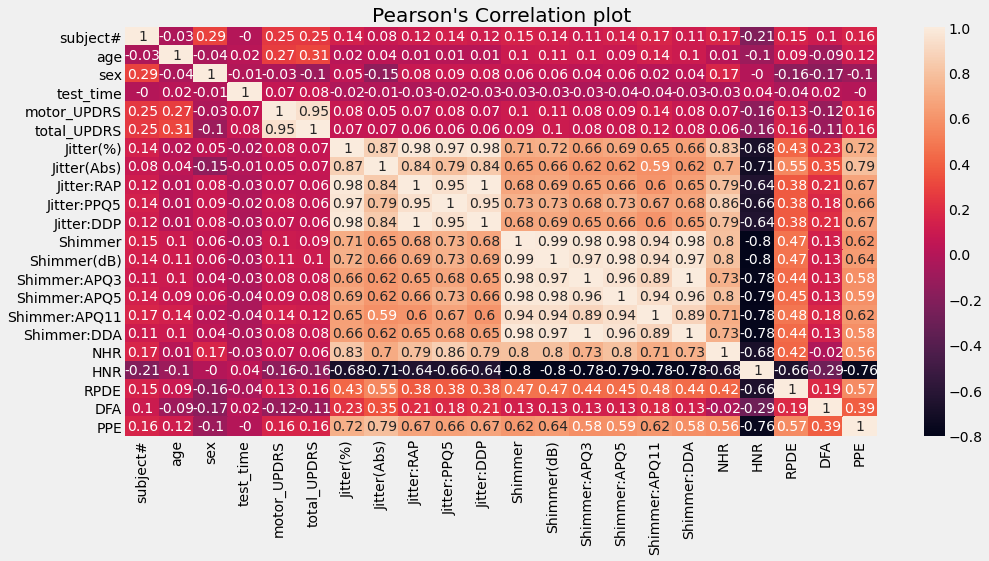

In [5]:
plt.figure(figsize=(15, 7))
sns.heatmap(round(df.corr(), 2), annot=True, )
plt.title("Pearson's Correlation plot")

In [6]:
len(df.columns)

22

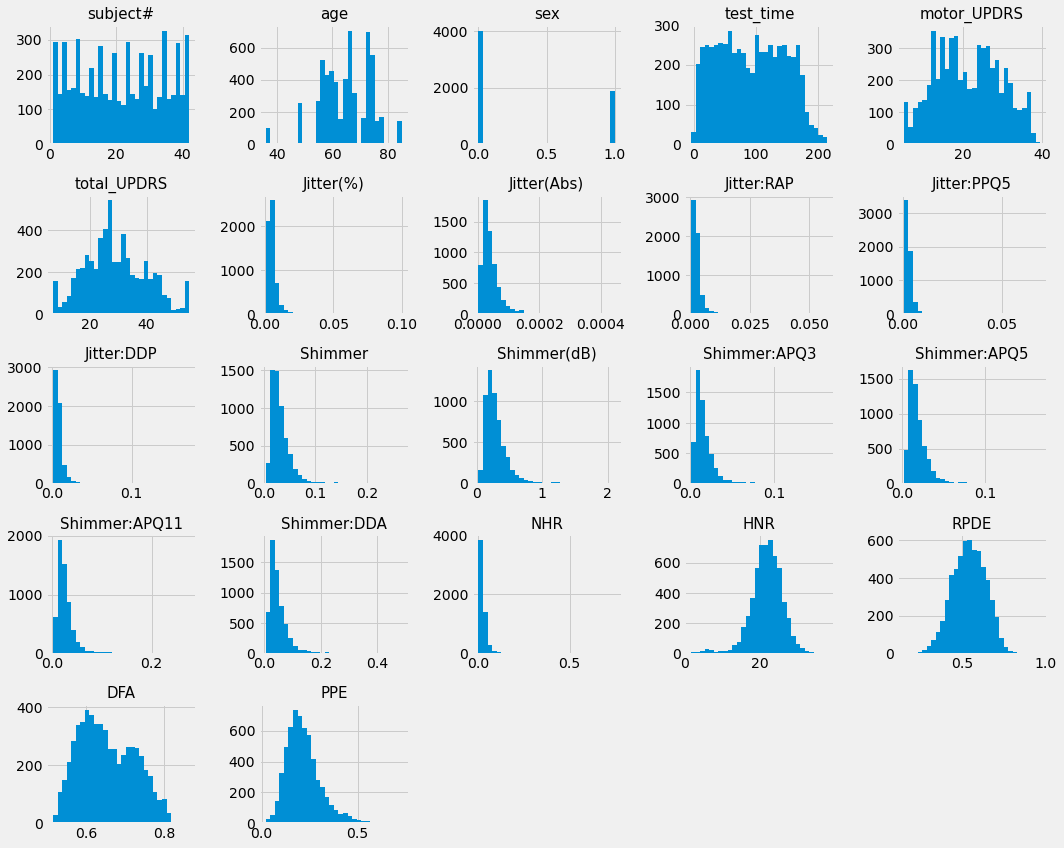

In [7]:
fig = df.hist(bins = 30, figsize=(15, 12))
[x.title.set_size(15) for x in fig.ravel()]
plt.tight_layout()
plt.show()

In [8]:
df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

interval columns not set, guessing: ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


<AxesSubplot:>

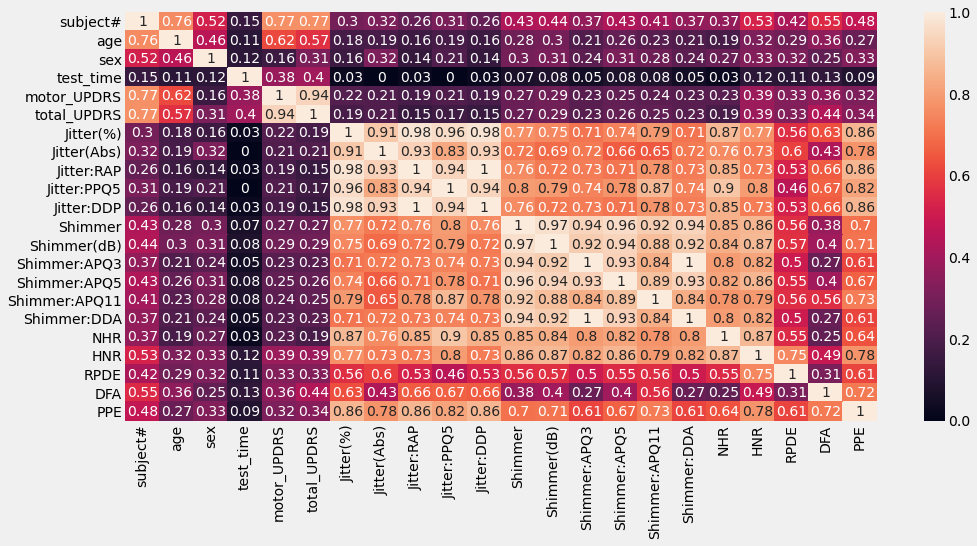

In [9]:
plt.figure(figsize=(15,7))
sns.heatmap(round(df.phik_matrix(), 2), annot=True)

In [10]:
class PrepareData:
    def __init__(self, filename = 'path', drop_columns = 'list of columns or empty list', target = 'y_variable', test_size = 0.3, add_intercept = True, random_state = 7):
        self.filename = filename
        self.target = target
        self.drop_columns = drop_columns
        self.test_size = test_size
        self.add_intercept = add_intercept
        self.random_state = random_state

    def read_dataset(self, filename):
        return pd.read_csv(filename).drop(self.drop_columns, axis = 1)

    def split_data_train_test(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size=self.test_size,
                                                            random_state=self.random_state)
        return X_train, X_test, y_train, y_test

    def add_intercept_to_data(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)

        X_norm = (X - mean) / std
        if self.add_intercept:
            X_norm = self.add_intercept_to_data(X_norm)

        return X_norm, mean, std

    def normalize_test(self, X, train_mean, train_std):
        X_norm = (X - train_mean) / train_std
        
        if self.add_intercept:
            X_norm = self.add_intercept_to_data(X_norm)

        return X_norm

    def transform(self):
        df = self.read_dataset(self.filename)
        y = df[self.target]
        X = df.drop(self.target, axis = 1)
        self.y = np.array(y)
        self.X = np.array(X)
        
        #self.X = df[:, 0:-1]
        #self.y = df[:, -1]
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data_train_test(
        )
        self.X_train, self.mean, self.std = self.normalize_train(self.X_train)
        self.X_test = self.normalize_test(self.X_test, self.mean, self.std)
        return self.X_train, self.y_train, self.X_test, self.y_test

## LINEAR REGRESSION

In [11]:
class LinearRegression:
    def __init__(self,
                 learning_rate,
                 lambda_value,
                 regularization,
                 max_iter,
                 tolerance,
                 method='ols, gd or sgd',
                 set_seed=7):
        self.learning_rate = learning_rate
        self.lambda_value = lambda_value
        self.regularization = regularization
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.method = method
        self.set_seed = set_seed

    def add_intercept(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def check_matrix_assumptions(self, X):
        x_rank = np.linalg.matrix_rank(X)

        if x_rank == min(X.shape[0], X.shape[1]):
            print('Matrix is full rank')
            self.full_rank = True
        else:
            print('Matrix is not full rank')
            self.full_rank = False

        if X.shape[0] < X.shape[1]:
            self.low_rank = True
            print('Data is low rank')
        else:
            self.low_rank = False
            print('Data is not low rank')

    def ols(self, X, y):
        if not self.regularization:
            w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            return w
        else:
            n = X.shape[1]
            I = np.eye((n))
            w = np.linalg.inv(X.T.dot(X) + self.lambda_value * I).dot(
                X.T).dot(y)
            return w

    def gradient_descent(self, X, y):
        self.error_history = []
        last_error = np.inf
        for i in tqdm(range(self.max_iter)):
            self.w = self.w - self.learning_rate * self.cost_derivative(X, y)
            current_error = self.rmse(X, y)
            diff_error = last_error - current_error
            last_error = current_error

            self.error_history.append(current_error)
            if diff_error < self.tolerance:
                print("The model has converged")
                break

    def stochastic_gradient_descent(self, X, y):
        self.error_history = []
        last_error = np.inf
        for i in tqdm(range(self.max_iter)):
            index = np.random.choice(X.shape[0],
                                     int(0.2 * X.shape[0]),
                                     replace=False)
            self.w = self.w - self.learning_rate * self.cost_derivative(
                X[index], y[index])
            current_error = self.rmse(X[index], y[index])
            diff_error = last_error - current_error
            last_error = current_error

            self.error_history.append(current_error)
            if abs(diff_error) < self.tolerance:
                print("The model has converged")
                break

    def predict(self, X):
        return X.dot(self.w)

    def sse(self, X, y):
        y_predicted = self.predict(X)
        # print(y_predicted)
        return ((y_predicted - y)**2).sum()

    def rmse(self, X, y):
        return np.sqrt((self.sse(X, y)) / X.shape[0])

    def score(self, X, y):
        print('Metrics with l2 Regularization:' if self.
              regularization else 'Metrics without Regularization')
        return print('RMSE test data:', self.rmse(X, y), '\n',
                     'SSE test data:', self.sse(X, y))

    def cost_derivative(self, X, y):
        y_predicted = self.predict(X)
        if not self.regularization:
            return (y_predicted - y).dot(X)
        else:
            return (y_predicted - y).dot(X) + (self.lambda_value * self.w)

    def plot_error_history(self, X, y):
        plt.figure(figsize=(12, 7))
        plt.plot(self.error_history)
        plt.title(r"Cost vs Epochs - {0} {1}".format(*[
            'Gradient Descent' if self.method ==
            'gd' else 'Stochastic Gradient Descent', 'with l2 Regularization'
            if self.regularization else 'without Regularization'
        ]))
        plt.xlabel("Epochs")
        plt.ylabel("Sum of Squared Errors")
        plt.text(x=int(len(self.error_history) * 0.6),
                 y=np.max(self.error_history) * 0.7,
                 s=r'RMSE={0:.3f}'.format(self.rmse(X, y)),
                 fontsize=20,
                 color=[0, 158 / 255, 115 / 255],
                 weight='bold',
                 rotation=0,
                 backgroundcolor='#f0f0f0')
        # plt.show()

    def fit(self, X, y):
        # Setting the random seed for reproducability
        np.random.seed(self.set_seed)

        # check for assumptions for closed form solution
        self.check_matrix_assumptions(X)

        if self.full_rank and not self.low_rank and X.shape[
                0] < 10000 and self.method == 'ols':
            print(
                "Solving using closed form solution/ Ordinary Least Squares method",
                'with l2 Regularization'
                if self.regularization else 'without Regularization')
            self.w = self.ols(X, y)
            print('RMSE:', self.rmse(X, y))
            print('SSE:', self.sse(X, y))

        elif self.method == 'gd':
            print(
                'Solving using Batch Gradient Descent',
                'with l2 Regularization'
                if self.regularization else 'without Regularization')
            self.w = np.zeros(X.shape[1], dtype=np.float64)
            self.gradient_descent(X, y)
            print('RMSE:', self.rmse(X, y))
            print('SSE:', self.sse(X, y))
            self.plot_error_history(X, y)

        elif self.method == 'sgd':
            print(
                'Solving using Stochastic Gradient Descent',
                'with l2 Regularization'
                if self.regularization else 'without Regularization')
            #self.w = np.random.rand(X.shape[1], 1)
            self.w = np.zeros(X.shape[1], dtype=np.float64)
            self.stochastic_gradient_descent(X, y)
            print('RMSE:', self.rmse(X, y))
            print('SSE:', self.sse(X, y))
            self.plot_error_history(X, y)

## MODELING

In [12]:
df = PrepareData(
    filename=url,
    drop_columns=['total_UPDRS'],
    target='motor_UPDRS',
    test_size=0.3)

In [13]:
X_train, y_train, X_test, y_test = df.transform()

In [14]:
ols_model = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
ols_model.fit(X_train, y_train)
ols_model.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method with l2 Regularization
RMSE: 7.211072386101172
SSE: 213822.21110561356
Metrics with l2 Regularization:
RMSE test data: 7.143711358886751 
 SSE test data: 89970.49491913142


Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

RMSE: 7.212397907471334
SSE: 213900.82686326554
Metrics with l2 Regularization:
RMSE test data: 7.141591923880413 
 SSE test data: 89917.11697035344


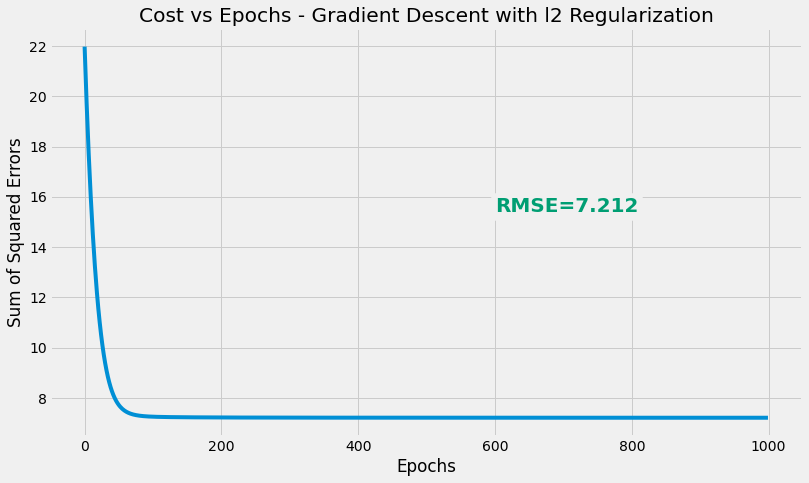

In [15]:
bgd_model = LinearRegression(learning_rate=0.00001,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.0,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgd_model.fit(X_train, y_train)
bgd_model.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

RMSE: 7.213769304070122
SSE: 213982.1786574799
Metrics with l2 Regularization:
RMSE test data: 7.140699475165745 
 SSE test data: 89894.64539753682


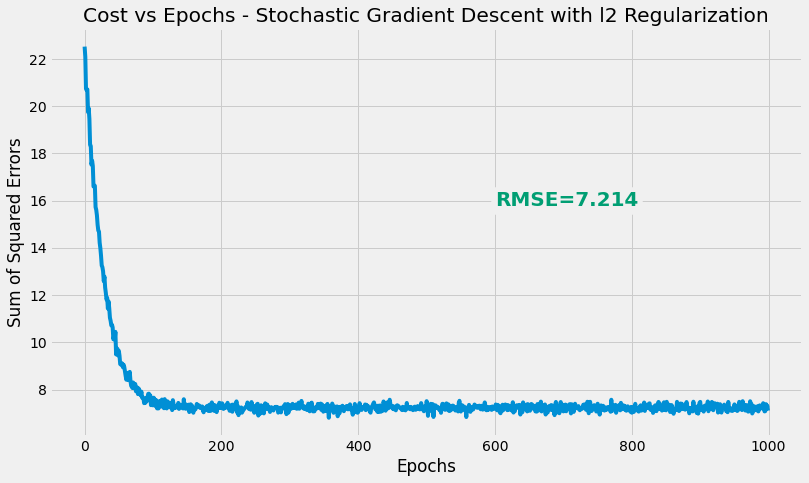

In [16]:
sgd_model = LinearRegression(learning_rate=0.00003,
                             lambda_value = 0.1,
                             regularization = True,
                             tolerance=0,
                             max_iter=1000,
                             method='sgd')

sgd_model.fit(X_train, y_train)
sgd_model.score(X_test, y_test)

## Dimensionality Reduction

## PCA

In [17]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        covariance_matrix = np.cov(X, rowvar=0)
        eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

        sorted_indexes = np.argsort(-eigen_values)
        eigen_values = eigen_values[sorted_indexes]
        eigen_vectors = eigen_vectors.T[sorted_indexes]

        # Choose principal components
        self.principal_components = eigen_vectors[:self.n_components, :]

        # Explained variance
        self.explained_variance = [
            (i / np.sum(eigen_values)) * 100 for i in eigen_values[:self.n_components]]

        # Cumulative explained variance
        self.total_explained_variance = np.cumsum(self.explained_variance)

    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.principal_components.T)


In [18]:
pca = PCA(n_components=2)

In [19]:
pca.fit(X_train[:,1:])

In [20]:
X_train_pca = pca.transform(X_train[:,1:])

In [21]:
X_train_pca

array([[ 0.58797637, -1.70409519],
       [-3.1405284 , -0.43301878],
       [ 2.50553402,  3.31163457],
       ...,
       [-0.04894854, -1.31725741],
       [ 1.4917508 ,  1.58106917],
       [ 2.14774209,  0.19519648]])

<AxesSubplot:>

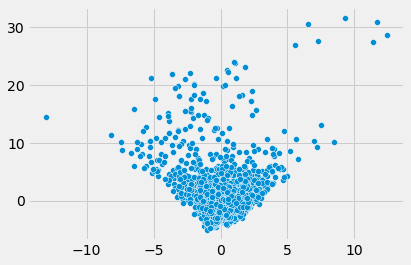

In [22]:
sns.scatterplot(x = X_train_pca[:, 1], y = X_train_pca[:, 0])

In [23]:
X_train_pca_intercept = np.insert(X_train_pca, 1, np.ones(X_train_pca.shape[0]), axis=1)

In [24]:
pca.explained_variance

[56.50808357347049, 8.680933047272113]

In [25]:
X_train.shape

(4112, 21)

In [26]:
X_train_pca.shape

(4112, 2)

In [27]:
ols_model = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
ols_model.fit(X_train_pca_intercept, y_train)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method with l2 Regularization
RMSE: 8.06401305935395
SSE: 267396.3968273245


Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

RMSE: 8.0650733805496
SSE: 267466.72030156787


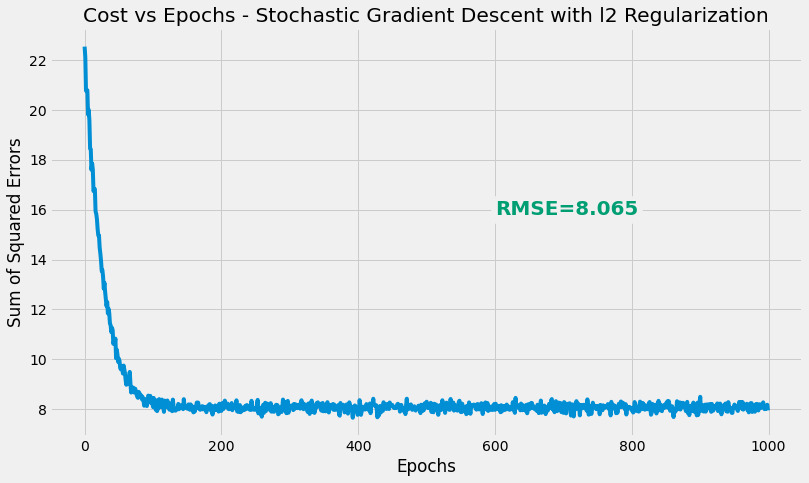

In [28]:
sgd_model = LinearRegression(learning_rate=0.00003,
                             lambda_value = 0.1,
                             regularization = True,
                             tolerance=0,
                             max_iter=1000,
                             method='sgd')

sgd_model.fit(X_train_pca_intercept, y_train)

## Neural Networks

In [29]:
class NNRegressor:
    def __init__(self, layers, loss, optimizer, learning_rate, max_iter):
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.params = {}
        self.hidden_layer = {}  # accessible variable
        self.optimizer = optimizer

    # Taken from itertools official documentation; itertools.pairwise deprecated
    def pairwise(self, iterable):
        # pairwise('ABCDEFG') --> AB BC CD DE EF FG
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)

    def init_params(self, layers):
        initializer = tf.initializers.GlorotNormal(seed=1)
        for i, j in enumerate(list(self.pairwise(self.layers)), 1):
            self.params['W_' + str(i)] = tf.Variable(
                initializer(shape=(j[1], j[0])), name=str('W_' + str(i)))
            self.params['b_' + str(i)] = tf.Variable(
                tf.random.normal(shape=(j[1], 1)), name=str('b_' + str(i)))

    def forward_propagation(self, X, update_hidden=True):
        hidden_layer = {}  # local variable
        for i in range(1, len(self.layers)):
            # first layer, so the input data matrix will multiplied with the weight matrix
            # W_ is weights
            # b_ is biases
            # H_ is hidden output
            # A_ is activation output
            if i == 1:
                hidden_layer['H_' + str(i)] = tf.add(
                    tf.matmul(self.params['W_' + str(i)], X), self.params['b_' + str(i)])
                hidden_layer['A_' +
                             str(i)] = tf.nn.relu(hidden_layer['H_' + str(i)])
            else:
                hidden_layer['H_' + str(i)] = tf.add(tf.matmul(self.params['W_' + str(
                    i)], hidden_layer['A_' + str(i - 1)]), self.params['b_' + str(i)])

                if i != (len(self.layers) - 1):
                    hidden_layer['A_' +
                                 str(i)] = tf.nn.relu(hidden_layer['H_' + str(i)])
                else:
                    hidden_layer['A_' + str(i)] = hidden_layer['H_' + str(i)]
            if update_hidden:
                self.hidden_layer = hidden_layer
            elif not update_hidden and i == (len(self.layers) - 1):
                return hidden_layer

    def predict(self, X):
        hidden_layer = self.forward_propagation(X, update_hidden=False)
        return hidden_layer['A_' + str(len(self.layers) - 1)]

    def backward_propagation(self, zip_grads_params):
        if self.optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=self.learning_rate)
            optimizer.apply_gradients(zip_grads_params)

    def compute_cost(self, X, y):
        y_predicted = self.predict(X)[0]
        cost = tf.reduce_sum(
            (y_predicted - tf.convert_to_tensor(y, np.float32))**2)
        return cost

    def get_grad(self, X, y):
        with tf.GradientTape() as tape:
            self.forward_propagation(X, update_hidden=True)
            loss_value = self.compute_cost(X, y)
        return [tape.gradient(loss_value, list(self.params.values())), loss_value]

    def stochastic_gradient_descent(self, X, y, data_subset):
        self.error_history = []
        last_error = np.inf
        for iter_ in tqdm(range(self.max_iter)):
            index = np.random.choice(X.shape[0],
                                     int(data_subset * X.shape[0]),
                                     replace=False)

            grads, current_error = self.get_grad(X[index].T, y[index])
            zip_grads_params = zip(grads, list(self.params.values()))

            y_pred = self.predict(X[index].T)[0]

            rmse_error = mean_squared_error(tf.convert_to_tensor(
                y[index], np.float32), y_pred, squared=False)

            # Backpropagation
            self.backward_propagation(zip_grads_params)

            print('Iteration:' + str(iter_) + ' sse = ' +
                  str(current_error.numpy()) + '  |  ' + ' rmse = ' + str(rmse_error) + '\n')

            self.error_history.append(rmse_error)

    def fit(self, X, y, data_subset):
        # First we initialize paramerters
        self.init_params(self.layers)
        # Now we iterate and use stochastic_gradient_descent
        self.stochastic_gradient_descent(X, y, data_subset)

In [30]:
df = PrepareData(
    filename=url,
    drop_columns=['total_UPDRS'],
    target='motor_UPDRS',
    test_size=0.3,
    add_intercept = False)

In [31]:
X_train, y_train, X_test, y_test = df.transform()

In [32]:
nnr = NNRegressor(layers = [20, 18, 15, 1], loss = 'rmse', optimizer = 'adam', learning_rate=0.001, max_iter=5000)

In [33]:
nnr.fit(X_train, y_train, 0.8)

  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration:0 sse = 1655114.5  |   rmse = 22.432726

Iteration:1 sse = 1661633.9  |   rmse = 22.476864

Iteration:2 sse = 1650022.4  |   rmse = 22.39819

Iteration:3 sse = 1630834.5  |   rmse = 22.267578

Iteration:4 sse = 1644751.6  |   rmse = 22.362392

Iteration:5 sse = 1625082.1  |   rmse = 22.228273

Iteration:6 sse = 1641143.6  |   rmse = 22.337852

Iteration:7 sse = 1626160.0  |   rmse = 22.235641

Iteration:8 sse = 1621991.1  |   rmse = 22.207123

Iteration:9 sse = 1624984.2  |   rmse = 22.227606

Iteration:10 sse = 1624795.6  |   rmse = 22.226315

Iteration:11 sse = 1606089.1  |   rmse = 22.097996

Iteration:12 sse = 1603874.0  |   rmse = 22.082752

Iteration:13 sse = 1603222.9  |   rmse = 22.07827

Iteration:14 sse = 1602661.6  |   rmse = 22.074406

Iteration:15 sse = 1595838.1  |   rmse = 22.02736

Iteration:16 sse = 1598698.0  |   rmse = 22.047092

Iteration:17 sse = 1581518.2  |   rmse = 21.928308

Iteration:18 sse = 1555273.1  |   rmse = 21.745602

Iteration:19 sse = 158094

Iteration:162 sse = 925597.75  |   rmse = 16.775644

Iteration:163 sse = 906169.6  |   rmse = 16.59865

Iteration:164 sse = 903531.3  |   rmse = 16.57447

Iteration:165 sse = 898385.25  |   rmse = 16.527205

Iteration:166 sse = 889024.7  |   rmse = 16.440878

Iteration:167 sse = 886977.9  |   rmse = 16.42194

Iteration:168 sse = 866368.94  |   rmse = 16.230036

Iteration:169 sse = 872773.0  |   rmse = 16.289911

Iteration:170 sse = 865548.56  |   rmse = 16.22235

Iteration:171 sse = 860604.1  |   rmse = 16.175951

Iteration:172 sse = 860306.1  |   rmse = 16.173145

Iteration:173 sse = 841194.3  |   rmse = 15.992496

Iteration:174 sse = 840190.56  |   rmse = 15.98295

Iteration:175 sse = 836081.7  |   rmse = 15.94382

Iteration:176 sse = 838428.2  |   rmse = 15.96618

Iteration:177 sse = 831063.44  |   rmse = 15.895901

Iteration:178 sse = 829598.06  |   rmse = 15.881881

Iteration:179 sse = 818647.44  |   rmse = 15.776712

Iteration:180 sse = 815472.5  |   rmse = 15.746088

Iteration:1

Iteration:332 sse = 213857.75  |   rmse = 8.06363

Iteration:333 sse = 220627.9  |   rmse = 8.190271

Iteration:334 sse = 218525.47  |   rmse = 8.1511545

Iteration:335 sse = 212020.55  |   rmse = 8.028918

Iteration:336 sse = 212507.12  |   rmse = 8.038125

Iteration:337 sse = 213750.89  |   rmse = 8.061614

Iteration:338 sse = 212704.5  |   rmse = 8.041859

Iteration:339 sse = 211701.81  |   rmse = 8.022881

Iteration:340 sse = 206586.53  |   rmse = 7.9253616

Iteration:341 sse = 206702.1  |   rmse = 7.9275784

Iteration:342 sse = 208760.89  |   rmse = 7.96696

Iteration:343 sse = 206740.67  |   rmse = 7.928317

Iteration:344 sse = 205939.16  |   rmse = 7.912933

Iteration:345 sse = 204381.23  |   rmse = 7.882947

Iteration:346 sse = 204885.75  |   rmse = 7.8926706

Iteration:347 sse = 202856.08  |   rmse = 7.8534794

Iteration:348 sse = 202837.38  |   rmse = 7.853117

Iteration:349 sse = 202815.06  |   rmse = 7.852685

Iteration:350 sse = 202020.7  |   rmse = 7.837292

Iteration:351

Iteration:489 sse = 152480.86  |   rmse = 6.808881

Iteration:490 sse = 155942.02  |   rmse = 6.8857245

Iteration:491 sse = 150628.3  |   rmse = 6.7673926

Iteration:492 sse = 154527.72  |   rmse = 6.854429

Iteration:493 sse = 152691.75  |   rmse = 6.813587

Iteration:494 sse = 152041.11  |   rmse = 6.799054

Iteration:495 sse = 152879.55  |   rmse = 6.817776

Iteration:496 sse = 150098.67  |   rmse = 6.755484

Iteration:497 sse = 152638.39  |   rmse = 6.8123965

Iteration:498 sse = 150737.27  |   rmse = 6.7698402

Iteration:499 sse = 151245.98  |   rmse = 6.781254

Iteration:500 sse = 154798.19  |   rmse = 6.8604245

Iteration:501 sse = 151807.6  |   rmse = 6.7938323

Iteration:502 sse = 150552.78  |   rmse = 6.765695

Iteration:503 sse = 148880.44  |   rmse = 6.7280135

Iteration:504 sse = 148477.4  |   rmse = 6.7189016

Iteration:505 sse = 150237.53  |   rmse = 6.758608

Iteration:506 sse = 150584.23  |   rmse = 6.7664022

Iteration:507 sse = 149925.66  |   rmse = 6.7515903

Itera

Iteration:650 sse = 122935.625  |   rmse = 6.113739

Iteration:651 sse = 124731.266  |   rmse = 6.1582274

Iteration:652 sse = 123503.64  |   rmse = 6.1278477

Iteration:653 sse = 123368.68  |   rmse = 6.124498

Iteration:654 sse = 124298.24  |   rmse = 6.1475286

Iteration:655 sse = 120985.66  |   rmse = 6.065059

Iteration:656 sse = 123417.18  |   rmse = 6.1257024

Iteration:657 sse = 123424.055  |   rmse = 6.1258726

Iteration:658 sse = 123630.61  |   rmse = 6.1309967

Iteration:659 sse = 121734.11  |   rmse = 6.08379

Iteration:660 sse = 122013.74  |   rmse = 6.0907736

Iteration:661 sse = 120294.555  |   rmse = 6.0477114

Iteration:662 sse = 123675.29  |   rmse = 6.1321044

Iteration:663 sse = 121287.38  |   rmse = 6.072617

Iteration:664 sse = 120030.94  |   rmse = 6.0410805

Iteration:665 sse = 119963.84  |   rmse = 6.0393925

Iteration:666 sse = 122399.14  |   rmse = 6.1003847

Iteration:667 sse = 123969.1  |   rmse = 6.139384

Iteration:668 sse = 120133.32  |   rmse = 6.043657

Iteration:814 sse = 102184.37  |   rmse = 5.573915

Iteration:815 sse = 102992.62  |   rmse = 5.5959153

Iteration:816 sse = 100986.6  |   rmse = 5.54115

Iteration:817 sse = 101488.73  |   rmse = 5.5549097

Iteration:818 sse = 103069.61  |   rmse = 5.598006

Iteration:819 sse = 103185.28  |   rmse = 5.601146

Iteration:820 sse = 100459.74  |   rmse = 5.5266767

Iteration:821 sse = 99722.26  |   rmse = 5.5063534

Iteration:822 sse = 99787.734  |   rmse = 5.508161

Iteration:823 sse = 100969.125  |   rmse = 5.540671

Iteration:824 sse = 100146.34  |   rmse = 5.5180507

Iteration:825 sse = 100590.15  |   rmse = 5.530263

Iteration:826 sse = 100968.43  |   rmse = 5.5406523

Iteration:827 sse = 101508.336  |   rmse = 5.555446

Iteration:828 sse = 98109.84  |   rmse = 5.461656

Iteration:829 sse = 101484.664  |   rmse = 5.554798

Iteration:830 sse = 99893.125  |   rmse = 5.511069

Iteration:831 sse = 98916.82  |   rmse = 5.484072

Iteration:832 sse = 100040.59  |   rmse = 5.5151362

Iterati

Iteration:976 sse = 86739.8  |   rmse = 5.1354356

Iteration:977 sse = 87589.41  |   rmse = 5.1605244

Iteration:978 sse = 86171.31  |   rmse = 5.1185794

Iteration:979 sse = 86681.086  |   rmse = 5.133697

Iteration:980 sse = 87621.99  |   rmse = 5.1614847

Iteration:981 sse = 86231.055  |   rmse = 5.120353

Iteration:982 sse = 87333.45  |   rmse = 5.1529784

Iteration:983 sse = 85728.23  |   rmse = 5.1054025

Iteration:984 sse = 86560.47  |   rmse = 5.1301246

Iteration:985 sse = 86458.31  |   rmse = 5.127096

Iteration:986 sse = 85986.734  |   rmse = 5.1130943

Iteration:987 sse = 86740.72  |   rmse = 5.1354623

Iteration:988 sse = 87143.7  |   rmse = 5.147378

Iteration:989 sse = 85322.9  |   rmse = 5.0933185

Iteration:990 sse = 85217.64  |   rmse = 5.090176

Iteration:991 sse = 85800.28  |   rmse = 5.107547

Iteration:992 sse = 86780.9  |   rmse = 5.136652

Iteration:993 sse = 85820.3  |   rmse = 5.108144

Iteration:994 sse = 85770.99  |   rmse = 5.1066766

Iteration:995 sse = 84


Iteration:1137 sse = 72996.38  |   rmse = 4.7110615

Iteration:1138 sse = 73446.02  |   rmse = 4.7255483

Iteration:1139 sse = 74520.3  |   rmse = 4.7599826

Iteration:1140 sse = 72880.805  |   rmse = 4.7073293

Iteration:1141 sse = 71293.0  |   rmse = 4.65577

Iteration:1142 sse = 73062.91  |   rmse = 4.713207

Iteration:1143 sse = 72608.766  |   rmse = 4.698537

Iteration:1144 sse = 73320.77  |   rmse = 4.7215176

Iteration:1145 sse = 72858.73  |   rmse = 4.706617

Iteration:1146 sse = 71243.21  |   rmse = 4.654144

Iteration:1147 sse = 72151.72  |   rmse = 4.683725

Iteration:1148 sse = 73075.03  |   rmse = 4.7135987

Iteration:1149 sse = 72043.88  |   rmse = 4.6802235

Iteration:1150 sse = 71577.43  |   rmse = 4.665048

Iteration:1151 sse = 71166.664  |   rmse = 4.651643

Iteration:1152 sse = 73212.99  |   rmse = 4.7180457

Iteration:1153 sse = 70846.14  |   rmse = 4.641156

Iteration:1154 sse = 72193.67  |   rmse = 4.6850867

Iteration:1155 sse = 72403.58  |   rmse = 4.691892

It

Iteration:1297 sse = 59289.145  |   rmse = 4.2457623

Iteration:1298 sse = 59718.984  |   rmse = 4.2611246

Iteration:1299 sse = 60261.957  |   rmse = 4.2804523

Iteration:1300 sse = 59894.863  |   rmse = 4.2673945

Iteration:1301 sse = 61622.008  |   rmse = 4.3284855

Iteration:1302 sse = 59798.707  |   rmse = 4.263968

Iteration:1303 sse = 59436.348  |   rmse = 4.2510295

Iteration:1304 sse = 61052.047  |   rmse = 4.3084216

Iteration:1305 sse = 59140.49  |   rmse = 4.2404356

Iteration:1306 sse = 59411.125  |   rmse = 4.2501273

Iteration:1307 sse = 59902.816  |   rmse = 4.2676783

Iteration:1308 sse = 59638.21  |   rmse = 4.258242

Iteration:1309 sse = 59281.457  |   rmse = 4.2454867

Iteration:1310 sse = 59662.348  |   rmse = 4.259104

Iteration:1311 sse = 59749.746  |   rmse = 4.2622223

Iteration:1312 sse = 60144.78  |   rmse = 4.2762895

Iteration:1313 sse = 58981.367  |   rmse = 4.234728

Iteration:1314 sse = 59998.28  |   rmse = 4.2710776

Iteration:1315 sse = 60026.977  |   

Iteration:1462 sse = 51081.355  |   rmse = 3.940935

Iteration:1463 sse = 51303.035  |   rmse = 3.949477

Iteration:1464 sse = 51104.855  |   rmse = 3.9418414

Iteration:1465 sse = 50359.734  |   rmse = 3.9129992

Iteration:1466 sse = 50684.203  |   rmse = 3.9255853

Iteration:1467 sse = 49882.6  |   rmse = 3.8944187

Iteration:1468 sse = 50529.08  |   rmse = 3.919573

Iteration:1469 sse = 49659.9  |   rmse = 3.8857155

Iteration:1470 sse = 50397.34  |   rmse = 3.9144597

Iteration:1471 sse = 50282.23  |   rmse = 3.9099872

Iteration:1472 sse = 50066.27  |   rmse = 3.9015815

Iteration:1473 sse = 50683.164  |   rmse = 3.9255447

Iteration:1474 sse = 49487.035  |   rmse = 3.8789465

Iteration:1475 sse = 51066.113  |   rmse = 3.9403472

Iteration:1476 sse = 49821.277  |   rmse = 3.892024

Iteration:1477 sse = 49724.16  |   rmse = 3.8882284

Iteration:1478 sse = 49824.1  |   rmse = 3.8921344

Iteration:1479 sse = 50864.22  |   rmse = 3.93255

Iteration:1480 sse = 50204.098  |   rmse = 3.9

Iteration:1624 sse = 45628.824  |   rmse = 3.7246692

Iteration:1625 sse = 44560.49  |   rmse = 3.680807

Iteration:1626 sse = 45222.184  |   rmse = 3.7080348

Iteration:1627 sse = 44584.01  |   rmse = 3.6817782

Iteration:1628 sse = 44711.145  |   rmse = 3.6870239

Iteration:1629 sse = 45185.84  |   rmse = 3.7065446

Iteration:1630 sse = 44414.51  |   rmse = 3.6747727

Iteration:1631 sse = 44997.508  |   rmse = 3.6988122

Iteration:1632 sse = 43782.02  |   rmse = 3.6485133

Iteration:1633 sse = 44507.652  |   rmse = 3.6786237

Iteration:1634 sse = 45203.883  |   rmse = 3.7072845

Iteration:1635 sse = 44169.26  |   rmse = 3.664613

Iteration:1636 sse = 44416.918  |   rmse = 3.6748722

Iteration:1637 sse = 44274.082  |   rmse = 3.6689587

Iteration:1638 sse = 43547.61  |   rmse = 3.6387334

Iteration:1639 sse = 43638.676  |   rmse = 3.6425357

Iteration:1640 sse = 43768.35  |   rmse = 3.647944

Iteration:1641 sse = 44237.367  |   rmse = 3.6674376

Iteration:1642 sse = 44597.914  |   rms

Iteration:1779 sse = 40129.48  |   rmse = 3.49301

Iteration:1780 sse = 40680.227  |   rmse = 3.5168982

Iteration:1781 sse = 39940.504  |   rmse = 3.4847755

Iteration:1782 sse = 40652.938  |   rmse = 3.5157173

Iteration:1783 sse = 39984.07  |   rmse = 3.486676

Iteration:1784 sse = 40216.234  |   rmse = 3.496784

Iteration:1785 sse = 38768.72  |   rmse = 3.433277

Iteration:1786 sse = 40851.316  |   rmse = 3.5242853

Iteration:1787 sse = 39290.88  |   rmse = 3.45632

Iteration:1788 sse = 39886.344  |   rmse = 3.4824119

Iteration:1789 sse = 39552.336  |   rmse = 3.4678004

Iteration:1790 sse = 41141.36  |   rmse = 3.5367746

Iteration:1791 sse = 40261.56  |   rmse = 3.4987535

Iteration:1792 sse = 39921.395  |   rmse = 3.483942

Iteration:1793 sse = 39764.99  |   rmse = 3.4771106

Iteration:1794 sse = 39428.58  |   rmse = 3.4623713

Iteration:1795 sse = 40385.402  |   rmse = 3.5041306

Iteration:1796 sse = 39746.754  |   rmse = 3.4763136

Iteration:1797 sse = 41087.53  |   rmse = 3.

Iteration:1934 sse = 37622.715  |   rmse = 3.382152

Iteration:1935 sse = 36917.56  |   rmse = 3.3503065

Iteration:1936 sse = 38700.785  |   rmse = 3.4302673

Iteration:1937 sse = 37128.9  |   rmse = 3.3598826

Iteration:1938 sse = 37319.21  |   rmse = 3.3684826

Iteration:1939 sse = 36885.004  |   rmse = 3.3488288

Iteration:1940 sse = 36442.836  |   rmse = 3.328696

Iteration:1941 sse = 36715.45  |   rmse = 3.341123

Iteration:1942 sse = 37638.098  |   rmse = 3.3828437

Iteration:1943 sse = 37336.582  |   rmse = 3.3692658

Iteration:1944 sse = 37931.1  |   rmse = 3.3959851

Iteration:1945 sse = 37654.234  |   rmse = 3.3835688

Iteration:1946 sse = 36868.1  |   rmse = 3.3480613

Iteration:1947 sse = 36873.785  |   rmse = 3.34832

Iteration:1948 sse = 36846.633  |   rmse = 3.3470864

Iteration:1949 sse = 37248.15  |   rmse = 3.3652742

Iteration:1950 sse = 37379.203  |   rmse = 3.371189

Iteration:1951 sse = 37707.797  |   rmse = 3.3859744

Iteration:1952 sse = 36570.707  |   rmse = 3

Iteration:2091 sse = 35361.953  |   rmse = 3.2789605

Iteration:2092 sse = 35848.9  |   rmse = 3.3014598

Iteration:2093 sse = 35895.633  |   rmse = 3.3036108

Iteration:2094 sse = 35483.613  |   rmse = 3.2845962

Iteration:2095 sse = 36364.977  |   rmse = 3.3251383

Iteration:2096 sse = 35573.82  |   rmse = 3.2887685

Iteration:2097 sse = 35673.758  |   rmse = 3.293385

Iteration:2098 sse = 34986.32  |   rmse = 3.2614987

Iteration:2099 sse = 35292.605  |   rmse = 3.2757437

Iteration:2100 sse = 35897.57  |   rmse = 3.3037

Iteration:2101 sse = 35805.414  |   rmse = 3.2994566

Iteration:2102 sse = 35664.82  |   rmse = 3.2929723

Iteration:2103 sse = 35223.164  |   rmse = 3.2725196

Iteration:2104 sse = 34834.63  |   rmse = 3.2544205

Iteration:2105 sse = 35150.688  |   rmse = 3.2691512

Iteration:2106 sse = 35348.855  |   rmse = 3.2783532

Iteration:2107 sse = 34572.207  |   rmse = 3.2421389

Iteration:2108 sse = 36206.652  |   rmse = 3.3178918

Iteration:2109 sse = 34700.92  |   rmse

Iteration:2249 sse = 34585.52  |   rmse = 3.2427628

Iteration:2250 sse = 33734.83  |   rmse = 3.202634

Iteration:2251 sse = 34385.184  |   rmse = 3.2333574

Iteration:2252 sse = 33725.387  |   rmse = 3.2021859

Iteration:2253 sse = 34136.316  |   rmse = 3.2216356

Iteration:2254 sse = 33871.64  |   rmse = 3.209122

Iteration:2255 sse = 34529.453  |   rmse = 3.240133

Iteration:2256 sse = 34192.766  |   rmse = 3.2242978

Iteration:2257 sse = 34328.19  |   rmse = 3.230677

Iteration:2258 sse = 32434.992  |   rmse = 3.1403277

Iteration:2259 sse = 34040.242  |   rmse = 3.2170985

Iteration:2260 sse = 34348.242  |   rmse = 3.2316206

Iteration:2261 sse = 33478.324  |   rmse = 3.1904354

Iteration:2262 sse = 34300.23  |   rmse = 3.229361

Iteration:2263 sse = 34038.84  |   rmse = 3.2170324

Iteration:2264 sse = 34633.777  |   rmse = 3.245025

Iteration:2265 sse = 32820.832  |   rmse = 3.1589506

Iteration:2266 sse = 34022.605  |   rmse = 3.216265

Iteration:2267 sse = 33813.35  |   rmse =

Iteration:2409 sse = 33090.04  |   rmse = 3.1718795

Iteration:2410 sse = 32392.277  |   rmse = 3.1382594

Iteration:2411 sse = 33373.625  |   rmse = 3.1854424

Iteration:2412 sse = 32334.998  |   rmse = 3.1354833

Iteration:2413 sse = 32988.715  |   rmse = 3.1670198

Iteration:2414 sse = 33589.004  |   rmse = 3.195704

Iteration:2415 sse = 33561.934  |   rmse = 3.1944163

Iteration:2416 sse = 33490.242  |   rmse = 3.191003

Iteration:2417 sse = 33518.67  |   rmse = 3.192357

Iteration:2418 sse = 33984.332  |   rmse = 3.2144556

Iteration:2419 sse = 33193.47  |   rmse = 3.176833

Iteration:2420 sse = 32926.992  |   rmse = 3.1640553

Iteration:2421 sse = 32701.693  |   rmse = 3.153212

Iteration:2422 sse = 33291.414  |   rmse = 3.1815166

Iteration:2423 sse = 32801.793  |   rmse = 3.1580343

Iteration:2424 sse = 33374.863  |   rmse = 3.1855016

Iteration:2425 sse = 33356.855  |   rmse = 3.184642

Iteration:2426 sse = 33035.633  |   rmse = 3.169271

Iteration:2427 sse = 32127.355  |   rm

Iteration:2572 sse = 32430.229  |   rmse = 3.1400971

Iteration:2573 sse = 31700.885  |   rmse = 3.1045866

Iteration:2574 sse = 32140.441  |   rmse = 3.1260362

Iteration:2575 sse = 32225.959  |   rmse = 3.1301918

Iteration:2576 sse = 32250.95  |   rmse = 3.1314056

Iteration:2577 sse = 31588.807  |   rmse = 3.0990934

Iteration:2578 sse = 32208.229  |   rmse = 3.1293309

Iteration:2579 sse = 33045.293  |   rmse = 3.1697342

Iteration:2580 sse = 31802.957  |   rmse = 3.1095808

Iteration:2581 sse = 32479.07  |   rmse = 3.1424606

Iteration:2582 sse = 32631.459  |   rmse = 3.1498241

Iteration:2583 sse = 32390.621  |   rmse = 3.138179

Iteration:2584 sse = 32307.662  |   rmse = 3.134158

Iteration:2585 sse = 32227.65  |   rmse = 3.1302745

Iteration:2586 sse = 32044.283  |   rmse = 3.121356

Iteration:2587 sse = 32266.15  |   rmse = 3.1321437

Iteration:2588 sse = 30936.537  |   rmse = 3.06693

Iteration:2589 sse = 32557.826  |   rmse = 3.1462686

Iteration:2590 sse = 32361.215  |   r

Iteration:2732 sse = 31720.04  |   rmse = 3.1055245

Iteration:2733 sse = 31313.225  |   rmse = 3.0855455

Iteration:2734 sse = 31907.105  |   rmse = 3.1146684

Iteration:2735 sse = 31793.602  |   rmse = 3.1091232

Iteration:2736 sse = 31376.135  |   rmse = 3.0886436

Iteration:2737 sse = 31469.469  |   rmse = 3.0932338

Iteration:2738 sse = 31175.223  |   rmse = 3.078739

Iteration:2739 sse = 31689.53  |   rmse = 3.1040306

Iteration:2740 sse = 31352.63  |   rmse = 3.0874863

Iteration:2741 sse = 31921.7  |   rmse = 3.1153803

Iteration:2742 sse = 31032.371  |   rmse = 3.071677

Iteration:2743 sse = 32074.01  |   rmse = 3.1228034

Iteration:2744 sse = 31517.834  |   rmse = 3.0956097

Iteration:2745 sse = 32112.5  |   rmse = 3.1246767

Iteration:2746 sse = 31414.318  |   rmse = 3.0905223

Iteration:2747 sse = 31187.49  |   rmse = 3.0793443

Iteration:2748 sse = 31622.799  |   rmse = 3.1007602

Iteration:2749 sse = 31807.158  |   rmse = 3.109786

Iteration:2750 sse = 31298.734  |   rmse

Iteration:2890 sse = 31620.4  |   rmse = 3.100643

Iteration:2891 sse = 31179.084  |   rmse = 3.0789294

Iteration:2892 sse = 30742.648  |   rmse = 3.0573044

Iteration:2893 sse = 31536.633  |   rmse = 3.0965328

Iteration:2894 sse = 30596.326  |   rmse = 3.05002

Iteration:2895 sse = 29883.559  |   rmse = 3.0142844

Iteration:2896 sse = 30869.225  |   rmse = 3.063592

Iteration:2897 sse = 30569.033  |   rmse = 3.0486596

Iteration:2898 sse = 31479.42  |   rmse = 3.0937233

Iteration:2899 sse = 30579.182  |   rmse = 3.0491652

Iteration:2900 sse = 30489.023  |   rmse = 3.0446672

Iteration:2901 sse = 30584.738  |   rmse = 3.0494425

Iteration:2902 sse = 31480.506  |   rmse = 3.0937765

Iteration:2903 sse = 30774.713  |   rmse = 3.0588987

Iteration:2904 sse = 30471.38  |   rmse = 3.043786

Iteration:2905 sse = 30410.18  |   rmse = 3.0407276

Iteration:2906 sse = 30496.541  |   rmse = 3.0450425

Iteration:2907 sse = 30159.768  |   rmse = 3.0281827

Iteration:2908 sse = 30918.678  |   rm

Iteration:3052 sse = 29588.197  |   rmse = 2.9993513

Iteration:3053 sse = 30528.656  |   rmse = 3.0466454

Iteration:3054 sse = 30640.707  |   rmse = 3.0522316

Iteration:3055 sse = 30562.02  |   rmse = 3.0483098

Iteration:3056 sse = 30311.572  |   rmse = 3.0357938

Iteration:3057 sse = 30269.99  |   rmse = 3.033711

Iteration:3058 sse = 30276.895  |   rmse = 3.034057

Iteration:3059 sse = 30654.676  |   rmse = 3.052927

Iteration:3060 sse = 29469.844  |   rmse = 2.9933467

Iteration:3061 sse = 29979.922  |   rmse = 3.0191405

Iteration:3062 sse = 30128.432  |   rmse = 3.026609

Iteration:3063 sse = 30326.07  |   rmse = 3.0365195

Iteration:3064 sse = 30474.445  |   rmse = 3.043939

Iteration:3065 sse = 30649.71  |   rmse = 3.0526803

Iteration:3066 sse = 30417.975  |   rmse = 3.0411174

Iteration:3067 sse = 30366.734  |   rmse = 3.0385551

Iteration:3068 sse = 31322.047  |   rmse = 3.0859804

Iteration:3069 sse = 29822.992  |   rmse = 3.0112283

Iteration:3070 sse = 30617.387  |   r

Iteration:3217 sse = 29524.996  |   rmse = 2.9961462

Iteration:3218 sse = 29604.803  |   rmse = 3.0001924

Iteration:3219 sse = 29280.121  |   rmse = 2.9836953

Iteration:3220 sse = 30145.293  |   rmse = 3.0274558

Iteration:3221 sse = 30171.926  |   rmse = 3.0287929

Iteration:3222 sse = 30275.639  |   rmse = 3.033994

Iteration:3223 sse = 29838.945  |   rmse = 3.0120337

Iteration:3224 sse = 29375.016  |   rmse = 2.9885266

Iteration:3225 sse = 29269.613  |   rmse = 2.98316

Iteration:3226 sse = 29704.994  |   rmse = 3.0052652

Iteration:3227 sse = 29064.973  |   rmse = 2.972713

Iteration:3228 sse = 29973.809  |   rmse = 3.0188324

Iteration:3229 sse = 29114.23  |   rmse = 2.9752312

Iteration:3230 sse = 29800.254  |   rmse = 3.01008

Iteration:3231 sse = 29574.678  |   rmse = 2.9986656

Iteration:3232 sse = 29634.117  |   rmse = 3.0016778

Iteration:3233 sse = 29673.592  |   rmse = 3.0036762

Iteration:3234 sse = 28953.8  |   rmse = 2.9670227

Iteration:3235 sse = 28997.799  |   r

Iteration:3375 sse = 28093.047  |   rmse = 2.9225874

Iteration:3376 sse = 29278.06  |   rmse = 2.9835908

Iteration:3377 sse = 30089.22  |   rmse = 3.0246391

Iteration:3378 sse = 30028.531  |   rmse = 3.0215871

Iteration:3379 sse = 29072.643  |   rmse = 2.9731054

Iteration:3380 sse = 29682.555  |   rmse = 3.00413

Iteration:3381 sse = 29686.688  |   rmse = 3.0043387

Iteration:3382 sse = 30099.021  |   rmse = 3.0251312

Iteration:3383 sse = 29835.38  |   rmse = 3.0118537

Iteration:3384 sse = 30316.385  |   rmse = 3.0360348

Iteration:3385 sse = 28987.87  |   rmse = 2.968768

Iteration:3386 sse = 28649.555  |   rmse = 2.9513927

Iteration:3387 sse = 30093.145  |   rmse = 3.0248363

Iteration:3388 sse = 29445.549  |   rmse = 2.9921124

Iteration:3389 sse = 29724.793  |   rmse = 3.0062668

Iteration:3390 sse = 29630.826  |   rmse = 3.0015109

Iteration:3391 sse = 29114.258  |   rmse = 2.9752326

Iteration:3392 sse = 29205.998  |   rmse = 2.9799166

Iteration:3393 sse = 29389.582  |  

Iteration:3536 sse = 28843.516  |   rmse = 2.9613667

Iteration:3537 sse = 28924.18  |   rmse = 2.9655044

Iteration:3538 sse = 29094.285  |   rmse = 2.974212

Iteration:3539 sse = 28615.828  |   rmse = 2.9496555

Iteration:3540 sse = 29393.541  |   rmse = 2.9894688

Iteration:3541 sse = 29377.506  |   rmse = 2.9886532

Iteration:3542 sse = 29330.965  |   rmse = 2.986285

Iteration:3543 sse = 29046.215  |   rmse = 2.9717538

Iteration:3544 sse = 29532.385  |   rmse = 2.9965212

Iteration:3545 sse = 29006.545  |   rmse = 2.969724

Iteration:3546 sse = 28568.096  |   rmse = 2.9471939

Iteration:3547 sse = 28592.77  |   rmse = 2.9484663

Iteration:3548 sse = 29421.97  |   rmse = 2.990914

Iteration:3549 sse = 29332.12  |   rmse = 2.9863436

Iteration:3550 sse = 29290.154  |   rmse = 2.9842067

Iteration:3551 sse = 29040.34  |   rmse = 2.9714534

Iteration:3552 sse = 29161.268  |   rmse = 2.977634

Iteration:3553 sse = 29051.06  |   rmse = 2.9720018

Iteration:3554 sse = 29536.936  |   rms

Iteration:3692 sse = 28600.045  |   rmse = 2.9488413

Iteration:3693 sse = 29225.258  |   rmse = 2.9808986

Iteration:3694 sse = 28449.848  |   rmse = 2.9410884

Iteration:3695 sse = 28618.729  |   rmse = 2.9498045

Iteration:3696 sse = 29030.623  |   rmse = 2.9709558

Iteration:3697 sse = 28464.266  |   rmse = 2.9418333

Iteration:3698 sse = 29186.793  |   rmse = 2.9789364

Iteration:3699 sse = 28727.926  |   rmse = 2.9554267

Iteration:3700 sse = 28956.203  |   rmse = 2.9671457

Iteration:3701 sse = 29171.223  |   rmse = 2.978142

Iteration:3702 sse = 28399.834  |   rmse = 2.9385016

Iteration:3703 sse = 28674.035  |   rmse = 2.9526534

Iteration:3704 sse = 28010.463  |   rmse = 2.9182885

Iteration:3705 sse = 28275.65  |   rmse = 2.9320703

Iteration:3706 sse = 28176.16  |   rmse = 2.9269073

Iteration:3707 sse = 28989.623  |   rmse = 2.9688573

Iteration:3708 sse = 28704.314  |   rmse = 2.9542117

Iteration:3709 sse = 28407.674  |   rmse = 2.9389071

Iteration:3710 sse = 28653.363 

Iteration:3855 sse = 28588.295  |   rmse = 2.9482353

Iteration:3856 sse = 28887.795  |   rmse = 2.9636385

Iteration:3857 sse = 28961.744  |   rmse = 2.9674296

Iteration:3858 sse = 27719.355  |   rmse = 2.903084

Iteration:3859 sse = 28632.064  |   rmse = 2.9504917

Iteration:3860 sse = 27676.152  |   rmse = 2.9008212

Iteration:3861 sse = 28065.543  |   rmse = 2.9211562

Iteration:3862 sse = 28307.605  |   rmse = 2.9337263

Iteration:3863 sse = 27896.82  |   rmse = 2.9123623

Iteration:3864 sse = 28232.266  |   rmse = 2.9298196

Iteration:3865 sse = 27970.492  |   rmse = 2.9162054

Iteration:3866 sse = 27972.451  |   rmse = 2.9163077

Iteration:3867 sse = 28299.09  |   rmse = 2.9332855

Iteration:3868 sse = 28331.775  |   rmse = 2.9349787

Iteration:3869 sse = 29047.018  |   rmse = 2.9717948

Iteration:3870 sse = 28523.105  |   rmse = 2.9448724

Iteration:3871 sse = 27575.129  |   rmse = 2.8955216

Iteration:3872 sse = 28264.24  |   rmse = 2.9314785

Iteration:3873 sse = 28667.852  

Iteration:4019 sse = 28244.887  |   rmse = 2.930475

Iteration:4020 sse = 28256.65  |   rmse = 2.9310849

Iteration:4021 sse = 27895.09  |   rmse = 2.9122722

Iteration:4022 sse = 28362.363  |   rmse = 2.9365625

Iteration:4023 sse = 28365.674  |   rmse = 2.9367342

Iteration:4024 sse = 28407.71  |   rmse = 2.9389095

Iteration:4025 sse = 28220.238  |   rmse = 2.9291956

Iteration:4026 sse = 28738.14  |   rmse = 2.9559522

Iteration:4027 sse = 28768.182  |   rmse = 2.9574966

Iteration:4028 sse = 28246.69  |   rmse = 2.930568

Iteration:4029 sse = 28741.105  |   rmse = 2.9561045

Iteration:4030 sse = 28097.893  |   rmse = 2.9228394

Iteration:4031 sse = 27582.133  |   rmse = 2.8958895

Iteration:4032 sse = 28253.318  |   rmse = 2.9309123

Iteration:4033 sse = 28753.43  |   rmse = 2.9567385

Iteration:4034 sse = 28915.057  |   rmse = 2.9650369

Iteration:4035 sse = 29057.568  |   rmse = 2.9723349

Iteration:4036 sse = 27501.99  |   rmse = 2.8916793

Iteration:4037 sse = 28334.004  |   r

Iteration:4172 sse = 28416.182  |   rmse = 2.9393473

Iteration:4173 sse = 27852.69  |   rmse = 2.910058

Iteration:4174 sse = 27900.19  |   rmse = 2.9125383

Iteration:4175 sse = 27075.402  |   rmse = 2.869165

Iteration:4176 sse = 27706.7  |   rmse = 2.9024212

Iteration:4177 sse = 28009.203  |   rmse = 2.9182227

Iteration:4178 sse = 27366.04  |   rmse = 2.8845232

Iteration:4179 sse = 28591.736  |   rmse = 2.9484131

Iteration:4180 sse = 27518.117  |   rmse = 2.8925269

Iteration:4181 sse = 28487.547  |   rmse = 2.9430358

Iteration:4182 sse = 27225.271  |   rmse = 2.8770947

Iteration:4183 sse = 28013.771  |   rmse = 2.9184608

Iteration:4184 sse = 28870.66  |   rmse = 2.9627593

Iteration:4185 sse = 28054.762  |   rmse = 2.9205952

Iteration:4186 sse = 27971.31  |   rmse = 2.916248

Iteration:4187 sse = 28022.104  |   rmse = 2.9188948

Iteration:4188 sse = 28234.979  |   rmse = 2.9299607

Iteration:4189 sse = 28164.105  |   rmse = 2.926281

Iteration:4190 sse = 27525.932  |   rms

Iteration:4329 sse = 27534.86  |   rmse = 2.8934066

Iteration:4330 sse = 27498.754  |   rmse = 2.8915093

Iteration:4331 sse = 27442.008  |   rmse = 2.888524

Iteration:4332 sse = 27878.25  |   rmse = 2.9113932

Iteration:4333 sse = 28234.248  |   rmse = 2.9299226

Iteration:4334 sse = 27056.777  |   rmse = 2.8681781

Iteration:4335 sse = 26996.168  |   rmse = 2.8649638

Iteration:4336 sse = 28932.914  |   rmse = 2.9659524

Iteration:4337 sse = 27510.342  |   rmse = 2.8921185

Iteration:4338 sse = 27673.785  |   rmse = 2.900697

Iteration:4339 sse = 27015.531  |   rmse = 2.8659909

Iteration:4340 sse = 27366.22  |   rmse = 2.8845327

Iteration:4341 sse = 27375.977  |   rmse = 2.885047

Iteration:4342 sse = 27990.117  |   rmse = 2.9172285

Iteration:4343 sse = 27622.621  |   rmse = 2.898014

Iteration:4344 sse = 27739.91  |   rmse = 2.90416

Iteration:4345 sse = 27680.998  |   rmse = 2.901075

Iteration:4346 sse = 27829.951  |   rmse = 2.90887

Iteration:4347 sse = 26952.816  |   rmse 

Iteration:4485 sse = 27487.45  |   rmse = 2.890915

Iteration:4486 sse = 27341.527  |   rmse = 2.8832307

Iteration:4487 sse = 26607.277  |   rmse = 2.8442538

Iteration:4488 sse = 26236.459  |   rmse = 2.824364

Iteration:4489 sse = 27254.361  |   rmse = 2.8786314

Iteration:4490 sse = 27296.703  |   rmse = 2.8808668

Iteration:4491 sse = 27272.104  |   rmse = 2.879568

Iteration:4492 sse = 27217.1  |   rmse = 2.876663

Iteration:4493 sse = 26999.975  |   rmse = 2.8651657

Iteration:4494 sse = 27386.094  |   rmse = 2.8855798

Iteration:4495 sse = 27172.076  |   rmse = 2.8742828

Iteration:4496 sse = 27240.096  |   rmse = 2.8778777

Iteration:4497 sse = 26809.166  |   rmse = 2.8550236

Iteration:4498 sse = 27893.287  |   rmse = 2.9121783

Iteration:4499 sse = 27538.227  |   rmse = 2.8935838

Iteration:4500 sse = 28749.947  |   rmse = 2.9565594

Iteration:4501 sse = 27663.47  |   rmse = 2.9001563

Iteration:4502 sse = 28012.38  |   rmse = 2.9183881

Iteration:4503 sse = 27680.643  |   r

Iteration:4646 sse = 26946.225  |   rmse = 2.862312

Iteration:4647 sse = 27145.016  |   rmse = 2.8728511

Iteration:4648 sse = 27265.656  |   rmse = 2.8792276

Iteration:4649 sse = 26624.303  |   rmse = 2.8451629

Iteration:4650 sse = 26743.664  |   rmse = 2.851534

Iteration:4651 sse = 26610.693  |   rmse = 2.844436

Iteration:4652 sse = 26588.543  |   rmse = 2.8432522

Iteration:4653 sse = 27464.834  |   rmse = 2.8897254

Iteration:4654 sse = 27672.826  |   rmse = 2.9006464

Iteration:4655 sse = 27209.898  |   rmse = 2.8762825

Iteration:4656 sse = 27189.729  |   rmse = 2.8752162

Iteration:4657 sse = 27161.475  |   rmse = 2.873722

Iteration:4658 sse = 27251.422  |   rmse = 2.8784761

Iteration:4659 sse = 27416.396  |   rmse = 2.887176

Iteration:4660 sse = 27312.06  |   rmse = 2.881677

Iteration:4661 sse = 27378.613  |   rmse = 2.885186

Iteration:4662 sse = 27123.662  |   rmse = 2.8717206

Iteration:4663 sse = 27785.111  |   rmse = 2.9065256

Iteration:4664 sse = 27165.791  |   

Iteration:4810 sse = 26763.55  |   rmse = 2.852594

Iteration:4811 sse = 26557.553  |   rmse = 2.8415945

Iteration:4812 sse = 27360.453  |   rmse = 2.884229

Iteration:4813 sse = 27326.236  |   rmse = 2.8824244

Iteration:4814 sse = 27181.434  |   rmse = 2.8747773

Iteration:4815 sse = 27933.44  |   rmse = 2.914273

Iteration:4816 sse = 27193.926  |   rmse = 2.8754377

Iteration:4817 sse = 27288.541  |   rmse = 2.880436

Iteration:4818 sse = 27411.092  |   rmse = 2.8868966

Iteration:4819 sse = 27058.389  |   rmse = 2.8682635

Iteration:4820 sse = 27019.664  |   rmse = 2.8662102

Iteration:4821 sse = 26944.936  |   rmse = 2.8622441

Iteration:4822 sse = 27364.492  |   rmse = 2.8844414

Iteration:4823 sse = 26847.271  |   rmse = 2.8570518

Iteration:4824 sse = 26341.123  |   rmse = 2.8299918

Iteration:4825 sse = 26965.943  |   rmse = 2.86336

Iteration:4826 sse = 26617.684  |   rmse = 2.8448093

Iteration:4827 sse = 26742.613  |   rmse = 2.8514776

Iteration:4828 sse = 26181.314  |   

Iteration:4970 sse = 26534.045  |   rmse = 2.8403368

Iteration:4971 sse = 26229.598  |   rmse = 2.8239946

Iteration:4972 sse = 26798.873  |   rmse = 2.8544753

Iteration:4973 sse = 25997.135  |   rmse = 2.8114526

Iteration:4974 sse = 26489.18  |   rmse = 2.8379343

Iteration:4975 sse = 27324.004  |   rmse = 2.8823068

Iteration:4976 sse = 26847.14  |   rmse = 2.857045

Iteration:4977 sse = 26349.129  |   rmse = 2.830422

Iteration:4978 sse = 27149.225  |   rmse = 2.873074

Iteration:4979 sse = 26297.566  |   rmse = 2.827651

Iteration:4980 sse = 27451.168  |   rmse = 2.8890061

Iteration:4981 sse = 26873.182  |   rmse = 2.8584304

Iteration:4982 sse = 26436.225  |   rmse = 2.8350961

Iteration:4983 sse = 26515.105  |   rmse = 2.8393223

Iteration:4984 sse = 27778.422  |   rmse = 2.9061759

Iteration:4985 sse = 26499.629  |   rmse = 2.8384938

Iteration:4986 sse = 26495.273  |   rmse = 2.8382607

Iteration:4987 sse = 25619.293  |   rmse = 2.7909472

Iteration:4988 sse = 26906.916  | 

## Decision Tree

In [34]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

In [35]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        dataset = np.concatenate((X, Y[:, np.newaxis]), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def score(self, X, y):
        return print('RMSE test data:', self.rmse(X, y), '\n',
                     'SSE test data:', self.sse(X, y))
    
    def sse(self, X, y):
        y_predicted = self.predict(X_test)
        #print(y_predicted)
        return ((y_predicted - y)**2).sum()

    def rmse(self, X, y):
        return np.sqrt((self.sse(X, y)) / X.shape[0])

In [36]:
df = PrepareData(
    filename=url,
    drop_columns=['total_UPDRS'],
    target='motor_UPDRS',
    test_size=0.3,
    add_intercept = False)

In [37]:
X_train, y_train, X_test, y_test = df.transform()

In [38]:
regressor = DecisionTreeRegressor(min_samples_split=6, max_depth=6)
regressor.fit(X_train,y_train)
regressor.print_tree()

X_0 <= 0.19836947242133074 ? 12.582909914884155
 left:X_0 <= -1.252185247074541 ? 15.088895576667902
  left:X_18 <= 0.6834530906420708 ? 21.84455892008082
    left:X_17 <= 0.820432745276081 ? 12.049642643453716
        left:X_0 <= -1.655117113601172 ? 4.196698775447592
                left:X_3 <= 0.21743712917117355 ? 5.5022885449253645
                                left:X_3 <= -0.6989892278266184 ? 0.9598546104989578
                                                                left:29.081799999999994
                                                                right:31.043962962962958
                                right:X_3 <= 0.8916926124515198 ? 1.2795418553791875
                                                                left:33.67733333333333
                                                                right:35.944714285714284
                right:X_1 <= 1.043868341957481 ? 5.802601320648966
                                left:X_1 <= -0.20066242699849426 ? 10.8

In [39]:
regressor.score(X_test, y_test)

RMSE test data: 2.321476016076077 
 SSE test data: 9501.24932474061


## K-Nearest-Neighbours

In [41]:
def euclidean_distance(a,b):
  a=np.array(a)
  b=np.array(b)
  diff = a-b
  distance = np.sqrt(np.dot(diff.T,diff))
  return distance

def KNN(X_train, y_train, X_test,y_test,neighbour):
  
  pred=[]
  
  
  for k in X_test:
      
      test_record=k
      distances=[]
      for i in X_train:
          distances=distances + [euclidean_distance(i,test_record)]
      knn_data = {'Distances':distances, 'UPDRS':y_train}  
      knn_df=pd.DataFrame(data=knn_data)
      knn_df_sorted=knn_df.sort_values(by=['Distances'])
      prediction = np.mean(knn_df_sorted['UPDRS'].head(neighbour).to_numpy())
      pred=pred+[prediction]
  
  #print(len(pred),len(y_test)) 
  RMSE=np.sqrt(mean_squared_error(y_test,pred))
  return RMSE
  #print(RMSE)

In [42]:
df = PrepareData(
    filename=url,
    drop_columns=['total_UPDRS'],
    target='motor_UPDRS',
    test_size=0.3,
    add_intercept = False)

In [43]:
X_train, y_train, X_test, y_test = df.transform()

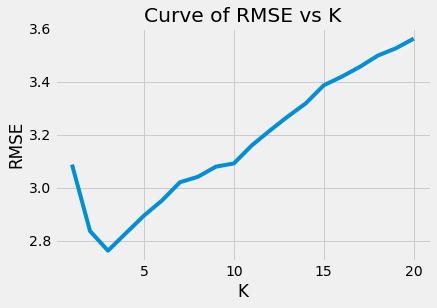

In [44]:
rmse = []
k=[]
for i in range(1,21):
  rmse+=[KNN(X_train,y_train,X_test,y_test,i)]
  k+=[i]

plt.plot(k, rmse)
plt.title("Curve of RMSE vs K")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.show()
  

In [46]:
rmse

[3.0867483084606135,
 2.8361971351202016,
 2.7618997287322338,
 2.8283154103370265,
 2.8941270894569064,
 2.951159181166157,
 3.0200997575663164,
 3.0407657674133124,
 3.0789831906712823,
 3.0911585404410027,
 3.159322340214638,
 3.215040858231142,
 3.26818761827304,
 3.3178943711825655,
 3.3860565258938693,
 3.418406272384235,
 3.455406059422817,
 3.4978163278255616,
 3.5252025883035087,
 3.5619913485992813]